In [1]:
# standard imports
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

# tensorflow
import tensorflow as tf
from matplotlib import rcParams
from numpy.linalg import norm

# sklearn
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# utils
from tqdm import tqdm
import random

In [2]:
# Just listing available devices to use with tensorflow

print('Available devices:')
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# To handle validation directories

class Dataset(object):

    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            # return filenames of all images
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)  # each image path

                if img_tmp.lower().endswith(('.jpg', '.jpeg')):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                        self.data_mapping[img_tmp] = c_name

        print(f'Loaded {len(self.data_mapping.keys())} from {self.data_path} images')

    def get_data_paths(self):
        # returns a list of img paths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.lower().endswith(('.jpg', '.jpeg')):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)

    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)

# define paths for all folders
data_path = 'dataset'
training_path = os.path.join(data_path, 'training')
validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(validation_path, 'gallery')
query_path = os.path.join(validation_path, 'query')

# create 'Dataset' objects for each folder
training_dataset = Dataset(training_path)
gallery_dataset = Dataset(gallery_path)
query_dataset = Dataset(query_path)

# get training/gallery/query data paths and classes
training_paths, training_classes = training_dataset.get_data_paths()
gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()

Loaded 10000 from dataset/training images
Loaded 800 from dataset/validation/gallery images
Loaded 100 from dataset/validation/query images


In [4]:
# Initialize the ResNet50 backbone

resnet = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

Metal device set to: Apple M1 Pro


2022-05-04 16:48:00.241195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-04 16:48:00.241311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# freeze the ResNet50
resnet.trainable = False

# initialize OUR model on top of it
inputs = tf.keras.Input(shape=(224, 224, 3))
x = resnet(inputs, training=False)
x = layers.Flatten(name='flatten2')(x)
x = layers.Dense(10, activation='softmax', name='dense5', kernel_regularizer='l1_l2')(x)
outputs = layers.Dropout(0.1, seed = 999)(x)

model = tf.keras.Model(inputs, outputs)

In [6]:
# Augment training data

def augment_img(img_path, n):
    data_aug = ImageDataGenerator(  # all augmentations we may perform
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    img = load_img(img_path)  # load as a PIL image
    arr_img = img_to_array(img)  # convert to a Numpy array with shape (3, 150, 150)
    exp_img = arr_img.reshape((1,) + arr_img.shape)  # add one more dim. to the shape, now (1, 3, 150, 150)

    cur_dir = os.path.dirname(img_path)  # current img directory

    prev_len = len(os.listdir(cur_dir))  # number of element current img directory

    cur_len = prev_len

    while cur_len - prev_len != n:  # until n new imgs are successfully created
        next(
            data_aug.flow(exp_img,
                          batch_size=1,
                          save_to_dir=cur_dir,
                          save_prefix='aug',
                          save_format='jpg')
        )

        cur_len = len(os.listdir(cur_dir))


# for img_path in tqdm(training_paths, desc='Augmenting training images'):
    # for each img of each class we're adding 3 more randomly augmented copies
    # augment_img(img_path, 3) ALREADY DONE

In [7]:
# Prepare training data

train_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    color_mode="rgb",
    seed = 99,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    color_mode="rgb",
    seed = 99,
    image_size=(224, 224),
    batch_size=32
)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


In [8]:
# Compile and fit model

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50


2022-05-04 16:48:16.981277: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-04 16:48:16.981526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 39.2547 - accuracy: 0.5263

2022-05-04 16:48:55.224936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 49s 190ms/step - loss: 39.2547 - accuracy: 0.5263 - val_loss: 35.0104 - val_accuracy: 0.8025
Epoch 2/50
250/250 [==============================] - 47s 187ms/step - loss: 33.2538 - accuracy: 0.7946 - val_loss: 29.8788 - val_accuracy: 0.8715
Epoch 3/50
250/250 [==============================] - 47s 188ms/step - loss: 27.9726 - accuracy: 0.8600 - val_loss: 24.9612 - val_accuracy: 0.8920
Epoch 4/50
250/250 [==============================] - 47s 187ms/step - loss: 23.1922 - accuracy: 0.8824 - val_loss: 20.4363 - val_accuracy: 0.9085
Epoch 5/50
250/250 [==============================] - 46s 185ms/step - loss: 18.8238 - accuracy: 0.8979 - val_loss: 16.4331 - val_accuracy: 0.9220
Epoch 6/50
250/250 [==============================] - 47s 186ms/step - loss: 15.0624 - accuracy: 0.9096 - val_loss: 13.0193 - val_accuracy: 0.9270
Epoch 7/50
250/250 [==============================] - 46s 185ms/step - loss: 11.9619 - accuracy: 0.9099 - val_loss: 10.2044 - val

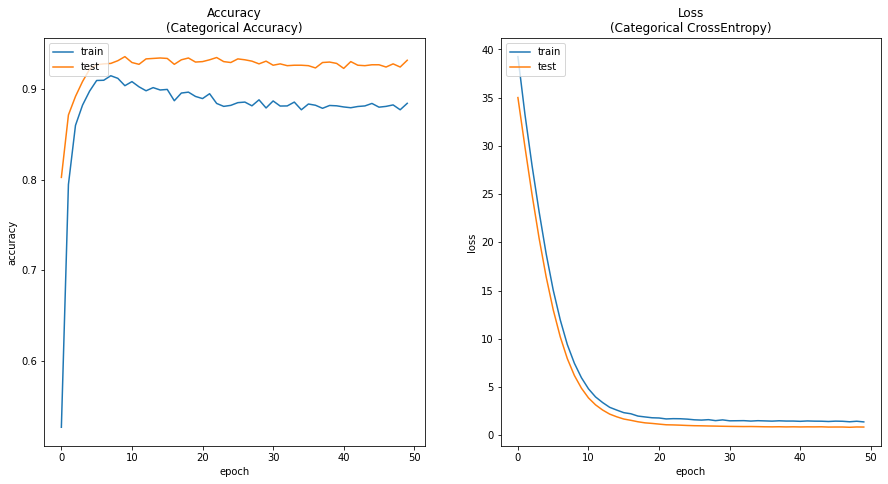

In [9]:
# Plot model training history

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Accuracy\n(Categorical Accuracy)')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Loss\n(Categorical CrossEntropy)')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')

#fig.tight_layout()
plt.show()

In [10]:
# Extract features from test images

def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)

    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

gallery_feats = list()
query_feats = list()

for i in tqdm(range(len(gallery_paths)), desc='Extracting gallery set features\t '):
    gallery_feats.append(extract_features(gallery_paths[i], model))

for i in tqdm(range(len(query_paths)), desc='Extracting query set features\t '):
    query_feats.append(extract_features(query_paths[i], model))

Extracting query set features	 : 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


In [11]:
# simulate a query-gallery search and evaluate it
def make_query(i, quiet=False, visual=False):

    kNN_model = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
    neighbors = kNN_model.fit(gallery_feats)

    dists, ids = neighbors.kneighbors([query_feats[i]])

    query_lab = query_dataset.data_mapping[query_paths[i]]

    if visual:

        plt.imshow(mpimg.imread(query_paths[i]))
        plt.title('Queried image', {'color': 'white'})  # for dark mode!
        plt.axis('off')

        plt.show()

        rcParams['figure.figsize'] = 15, 5

        f, axarr = plt.subplots(2, 5)

        n = 0
        for r in range(2):
            for c in range(5):
                axarr[r, c].imshow(mpimg.imread(gallery_paths[ids[0][n]]))
                axarr[r, c].axis('off')
                n += 1

        plt.show()

    if not quiet:
        print(f'Queried img:\n{query_lab}')
        print('\nRetrieved imgs:')

    matches = list()

    for ind in ids[0]:

        gallery_lab = gallery_dataset.data_mapping[gallery_paths[ind]]

        if query_lab == gallery_lab:
            matches.append(True)
            if not quiet:
                print(gallery_lab, '○')
        else:
            matches.append(False)
            if not quiet:
                print(gallery_lab, '✕')

    top1acc, top3acc, top5acc = sum(matches[:1]) / 1, sum(matches[:3]) / 3, sum(matches[:5]) / 5

    if not quiet:
        print('\nRESULTS')
        print(f'Top-1 accuracy is: {top1acc}')
        print(f'Top-3 accuracy is: {top3acc}')
        print(f'Top-5 accuracy is: {top5acc}')

    return top1acc, top3acc, top5acc

# perform evaluation on whole query dataset
def evaluation():

    all_t1, all_t3, all_t5 = list(), list(), list()

    for i in tqdm(range(len(query_feats)), desc='testing on all queries'):

        t1, t3, t5 = make_query(i, quiet=True)

        all_t1.append(t1)
        all_t3.append(t3)
        all_t5.append(t5)

    print('RESULTS:')
    print(f'top-1 accuracy: {round(np.mean(all_t1), 2)}')
    print(f'top-3 accuracy: {round(np.mean(all_t3), 2)}')
    print(f'top-5 accuracy: {round(np.mean(all_t5), 2)}')

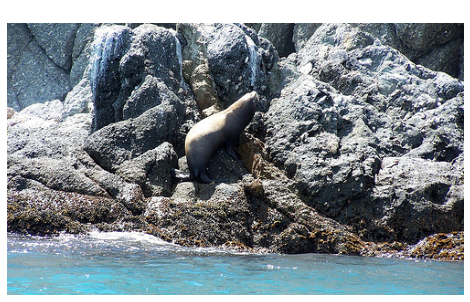

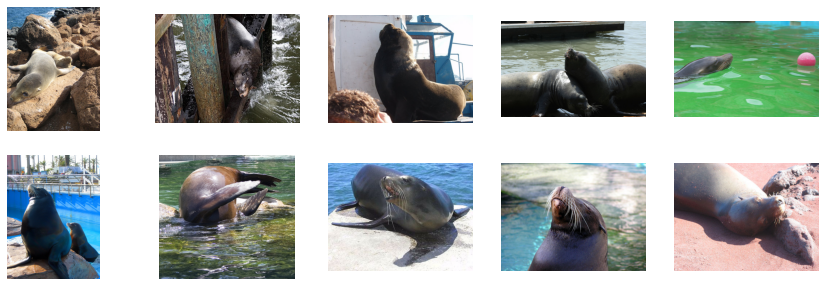

Queried img:
n02077923(sea_lion)

Retrieved imgs:
n02077923(sea_lion) ○
n02077923(sea_lion) ○
n02077923(sea_lion) ○
n02077923(sea_lion) ○
n02077923(sea_lion) ○
n02077923(sea_lion) ○
n02077923(sea_lion) ○
n02077923(sea_lion) ○
n02077923(sea_lion) ○
n02077923(sea_lion) ○

RESULTS
Top-1 accuracy is: 1.0
Top-3 accuracy is: 1.0
Top-5 accuracy is: 1.0


(1.0, 1.0, 1.0)

In [18]:
# just trying

i = random.randint(1,99)
make_query(i, visual=True)

In [17]:
# How did the model score?

evaluation()

testing on all queries: 100%|██████████| 100/100 [00:00<00:00, 3891.51it/s]

RESULTS:
top-1 accuracy: 0.88
top-3 accuracy: 0.89
top-5 accuracy: 0.89
